#### Download kaggle dataset for the first time

In [ ]:
# Installs the Kaggle API Client
! pip install -q kaggle

# Upload kaggle.json file into Files
# from google.colab import files
# files.upload()

# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command
# This display all datasets available on Kaggle via the Kaggle API
! kaggle datasets list

# Download competition datasets from Kaggle via the Kaggle API
! kaggle competitions download -c home-credit-credit-risk-model-stability
! mkdir ~/.kaggle/dataset
! unzip home-credit-credit-risk-model-stability -d ~/.kaggle/dataset

In [ ]:
# Copy the dataset into MyDrive in Google Drive
!cp -r /root/.kaggle/kaggle.json /content/drive/MyDrive
!cp -r /root/.kaggle/dataset /content/drive/MyDrive

#### Combine datasets

In [ ]:
dfs = [pl.read_parquet(file).pipe(Pipeline.set_dtypes) for file in glob(str(TEST_DIR_ALL / "test_static_0_*.parquet"))]
print([dfs[0].columns == df.columns for df in dfs])
print(sum(len(set(df['case_id'])) for df in dfs))
print(len(set.union(*(set(df['case_id']) for df in dfs))))
df = pl.concat(dfs)
len(set(df['case_id']))

[True, True, True]
30
30


30

In [ ]:
df.write_parquet(TEST_DIR / "test_static_0.parquet")
pl.read_parquet(TEST_DIR / "test_static_0.parquet")

#### Data is too big, we randomly select some data

In [ ]:
import random

# Define the range, subset size, and random seed
total_range = 3000000
subset_size = 100000

# Set the random seed
random.seed(42)

# Generate a random subset of the specified size
subset = random.sample(range(1, total_range + 1), subset_size)

# Get all test ids
test_ids = set()
for filename in os.listdir(ROOT / "parquet_files" / "test"):
    df = pl.read_parquet(ROOT / "parquet_files" / "test" / filename)
    test_ids |= set(df['case_id'])
test_ids

# Union to form the selected ids
selected_ids = set(subset) | test_ids

In [ ]:
os.listdir(TRAIN_DIR_ALL)

In [ ]:
filename = "train_base.parquet"
df = pl.read_parquet(TRAIN_DIR_ALL / filename)
df = df.filter(pl.col('case_id').is_in(selected_ids))

In [ ]:
df.write_parquet(TRAIN_DIR / filename)
pl.read_parquet(TRAIN_DIR / filename)

In [ ]:
# multiple storage for "train_credit_bureau_a_2_5.parquet" since it is an unusually large file

'''
col_name = pl.read_csv(ROOT / "csv_files/train" / "train_credit_bureau_a_2_5.csv", n_rows=10000000).columns
df = pl.read_csv(ROOT / "csv_files/train" / "train_credit_bureau_a_2_5.csv", skip_rows=30000000, n_rows=10000000)
df.columns = col_name
df = df.filter(pl.col('case_id').is_in(selected_ids))
df.write_parquet(ROOT / "parquet_files/selected_train" / "train_credit_bureau_a_2_5_3.parquet")
pl.read_parquet(ROOT / "parquet_files/selected_train" / "train_credit_bureau_a_2_5_3.parquet")
'''

# **Home Credit Notebook**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
from pathlib import Path
from datetime import datetime
import polars as pl
# pl deals with parquet files efficiently
import gc
from glob import glob
# glob search for files more effectively
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [18]:
ROOT = Path("/content/drive/MyDrive/dataset/")
TRAIN_DIR_ALL = ROOT / "parquet_files" / "train"
TRAIN_DIR = ROOT / "parquet_files" / "selected_train"
TEST_DIR  = ROOT / "parquet_files" / "test"


# feature_definitions = pd.read_csv(ROOT / "feature_definitions.csv")
# feature_definitions = dict(feature_definitions.to_numpy())
with open(ROOT / 'feature_definitions.json', 'r') as f:
    feature_definitions = json.load(f)


CAT_NAN_VALUE = '_NAN_VALUE_'  # to fill NaNs in categorical columns
CAT_RARE_VALUE = '_RARE_VALUE_'  # to replace rare categorical values

In [184]:
dict((f, feature_definitions[f]) for f in ['description_5085714M',
 'for3years_128L',
 'formonth_118L',
 'formonth_206L',
 'forquarter_1017L',
 'forquarter_462L',
 'forweek_1077L',
 'forweek_601L',
 'foryear_618L'])

{'description_5085714M': 'Categorization of clients by credit bureau.',
 'for3years_128L': 'Number of rejected applications in the past 3 years.',
 'formonth_118L': 'Number of rejections in a month.',
 'formonth_206L': 'Number of cancelations in the previous month.',
 'forquarter_1017L': 'Number of cancellations recorded in the credit bureau in the last quarter.',
 'forquarter_462L': 'Number of credit applications that were rejected in the last quarter.',
 'forweek_1077L': 'Number of cancelations in the last week.',
 'forweek_601L': 'Number of rejected applications in the last week.',
 'foryear_618L': 'Number of application rejections in the previous year.'}

In [180]:
col_file['for3years_584L']

{PosixPath('/content/drive/MyDrive/dataset/parquet_files/selected_train/train_static_cb_0.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/test/test_static_cb_0.parquet')}

In [189]:
df = pl.read_parquet(TRAIN_DIR / "train_static_cb_0.parquet")
df

case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
i64,str,str,str,str,f64,str,str,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64
388,null,null,null,"""1989-04-01""",null,"""1989-04-01""",null,6.0,8.0,2.0,10.0,4.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.0,"""a55475b1""","""a55475b1""",10.0,null,null,null,null,null,null,6.0,14548.0,null,"""2019-01-28""",null,null,null,null,3.0,5.0
422,"""2015-06-22""",null,null,"""1957-06-01""",null,"""1957-06-01""",null,3.0,3.0,0.0,6.0,3.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.0,"""3439d993""","""a55475b1""",6.0,14051.867,null,null,null,null,6.0,null,null,null,"""2019-01-22""",null,null,null,null,4.0,0.0
444,"""2016-08-12""",null,null,"""1953-08-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,6600.5337,null,null,null,null,6.0,null,null,null,"""2019-01-22""",null,null,null,null,null,null
505,null,null,null,"""1984-12-01""",null,"""1984-12-01""",null,11.0,14.0,0.0,20.0,8.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8.0,"""a55475b1""","""a55475b1""",20.0,null,null,null,null,null,null,6.0,11261.872,null,"""2019-01-22""",null,null,null,null,4.0,6.0
506,"""2018-03-23""",null,null,"""1955-03-01""",null,"""1955-03-01""",null,1.0,1.0,0.0,2.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,"""3439d993""","""a55475b1""",2.0,6852.234,null,null,null,null,6.0,null,null,null,"""2019-01-22""",null,null,null,null,0.0,2.0
518,null,null,null,"""1995-06-01""",null,"""1995-06-01""",null,2.0,2.0,2.0,2.0,2.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,"""3439d993""","""a55475b1""",2.0,null,null,null,null,null,null,9.0,3462.8,null,"""2019-01-22""",null,null,null,null,0.0,0.0
558,null,null,null,"""1961-10-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,7.0,8280.0,null,"""2019-01-22""",null,null,null,null,null,null
611,null,null,null,"""1956-12-01""",null,"""1956-12-01""",null,4.0,4.0,2.0,5.0,2.0,"""a55475b1""","""a55475b1""","""a55475b1""",1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.0,"""a55475b1""","""a55475b1""",5.0,null,null,null,null,null,null,6.0,5465.8003,null,"""2019-01-23""",null,null,null,null,0.0,2.0
619,null,null,null,"""1956-03-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,n

In [205]:
feature_list = [(f, feature_definitions[f], list(df[f].unique())) for f in df.columns if f in feature_definitions]
feature_list = sorted(feature_list, key=lambda x: len(x[2]))

dff = pd.DataFrame(feature_list, columns=['feature', 'description', 'unique_values'])

In [204]:
dff[dff['unique_values'].apply(lambda x: len(x) <= 2)]['feature'].to_list()

['description_5085714M',
 'for3years_128L',
 'formonth_118L',
 'formonth_206L',
 'forquarter_1017L',
 'forquarter_462L',
 'forweek_1077L',
 'forweek_601L',
 'foryear_618L']

## Pipeline

In [24]:
class Pipeline:

    @staticmethod
    def set_dtypes(df):
        '''
        Reset the data type of columns
        '''
        for col in df.columns:
            if col in ['MONTH', 'WEEK_NUM', 'case_id', 'num_group1', 'num_group2']:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ('M',) or col in [
                'riskassesment_302T',
                'cardtype_51L',
                'credacc_cards_status_52L',
                'empl_industry_691L',
                'credacc_status_367L',
                'empl_employedtotal_800L',
                'empl_industry_691L',
                'periodicityofpmts_997L',
                'requesttype_4525192L'
            ]:
                df = df.with_columns(pl.col(col).cast(pl.Utf8))
            elif col in ['equalityempfrom_62L', 'isbidproductrequest_292L', 'isdebitcard_527L']:
                df = df.with_columns(pl.col(col).cast(pl.Boolean))
            elif col in ['date_decision'] or col[-1] in ('D'):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df


    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
        df = df.drop("date_decision", "MONTH")
        return df


    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                if df[col].is_null().mean() > 0.95:
                    df = df.drop(col)
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) and (df[col].dtype == pl.Utf8):
                freq = df[col].n_unique()
                if (freq <= 1) or (freq > 255):
                    df = df.drop(col)
        return df

## File I/O

In [170]:
def read_file(path):
    '''
    Read parquet file, set the data type of columns
    '''
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_dtypes)
    return df

## Feature Engineering

In [ ]:
class Aggregator:


    @staticmethod
    def _applicant_max_expr(df, depth, cols):
        redundant_cols = [
            'creationdate_885D',
            'recorddate_4527225D',
            'deductiondate_4917603D',
            'debtoutstand_525A',
            'debtoverdue_47A',
            'empl_employedfrom_271D',
            'empl_employedtotal_800L',
            'empl_industry_691L',
            'familystate_447L',
            'housetype_905L',
            'incometype_1044T',
            'safeguarantyflag_411L',
            'sex_738L',
            'revolvingaccount_394A',
            'residualamount_488A',
            'instlamount_768A',
            'instlamount_852A',
            'outstandingamount_362A',
            'totaldebtoverduevalue_178A',
            'totaloutstanddebtvalue_39A',
            'dateofcredstart_181D',
            'numberofoverdueinstlmaxdat_641D',
            'overdueamountmax2date_1142D',
            'numberofcontrsvalue_258L',
            'maxdpdtolerance_577P',
            'outstandingdebt_522A',
            'actualdpd_943P',
            'financialinstitution_591M',
            'contractst_545M',
            'contractst_964M',
        ]
        return [
            pl.col("num_group1", col)
            .filter(pl.col("num_group1") == 0)
            .exclude("num_group1")
            .max()
            .alias(f"applicant_max_{col}")
            for col in cols if col not in redundant_cols
        ]


    @staticmethod
    def _above_expr(df, depth, cols, threshold):
        return [
            pl.col(col)
            .filter(pl.col(col) > threshold)
            .count()
            .cast(pl.Float64)
            .truediv(1 + pl.count())
            .alias(f"above_{threshold}_share_{col}")
            for col in cols
        ]


    @staticmethod
    def _mode_share_expr(df, depth, cols):
        additional_param_cols = [
            'numberofoverdueinstlmax_1151L',
            'postype_4733339M',
            'rejectreasonclient_4145042M',
            'purposeofcred_874M',
            'purposeofcred_426M',
            'purposeofcred_722M',
            'classificationofcontr_13M',
            'contractst_545M',
            'financialinstitution_591M',
            'numberofoutstandinstls_520L',
            'employername_M',
            'name_4527232M',
            'name_4917606M',
            'employername_160M',
            'numberofcontrsvalue_358L',
            'contaddr_district_15M',
            'registaddr_district_1083M',
            'empladdr_district_926M',
            'empladdr_zipcode_114M',
        ]
        expr = []
        for col in cols:
            if df[col].dtype == pl.Utf8:
                mode = pl.col(col).drop_nulls().mode().max()
                expr.append(mode.alias(f"mode_{col}"))
                if col in additional_param_cols:
                    expr.append(
                        (pl.col(col) == mode).cast(pl.Float64).sum()
                        .truediv(1 + pl.count())
                        .alias(f"mode_additional_param_{col}")
                    )
            else:
                expr.append(pl.mean(col).alias(f"mode_{col}"))
                if col in additional_param_cols:
                    expr.append(pl.max(col).alias(f"mode_additional_param_{col}"))
        return expr


    @staticmethod
    def num_dpd_expr(df, depth):
        redundant_cols = [
            'avgdbdtollast24m_4525197P',
        ]
        cols = [col for col in df.columns if (col[-1] == "P") and (col not in redundant_cols)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_above = Aggregator._above_expr(
            df, depth, [col for col in cols if 'pmts_dpd' in col], threshold=0.0
        )
        if depth == 2:
            return expr_mean + expr_max + expr_above
        expr_applicant_max = Aggregator._applicant_max_expr(df, depth, cols)
        return expr_mean + expr_max + expr_above + expr_applicant_max


    @staticmethod
    def num_amnt_expr(df, depth):
        redundant_cols = [
            'avgpmtlast12m_4525200A',
            'disbursedcredamount_1113A',
            'maxpmtlast3m_4525190A',
            'pmtamount_36A',
            'totaloutstanddebtvalue_668A',
            'mainoccupationinc_384A',
            'credacc_credlmt_575A',
        ]
        cols = [col for col in df.columns if (col[-1] == "A") and (col not in redundant_cols)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [
            pl.min(col).alias(f"min_{col}") for col in cols if col not in [
                'debtoutstand_525A',
                'debtoverdue_47A',
                'outstandingamount_362A',
                'residualamount_488A',
                'totalamount_996A',
                'credlmt_935A',
                'residualamount_856A',
                'instlamount_768A',
            ]
        ]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_std = [pl.std(col).alias(f"std_{col}") for col in cols if 'amount' in col]
        if depth == 2:
            return expr_max + expr_min + expr_mean + expr_std
        expr_applicant_max = Aggregator._applicant_max_expr(df, depth, cols)
        return expr_max + expr_min + expr_mean + expr_std + expr_applicant_max


    @staticmethod
    def date_expr(df, depth):
        redundant_cols = [
            'responsedate_1012D',
            'processingdate_168D',
            'numberofoverdueinstlmaxdat_148D',
        ]
        cols = [col for col in df.columns if (col[-1] == "D") and (col not in redundant_cols)]
        expr_max = [
            pl.max(col).alias(f"max_{col}") for col in cols if col not in [
                'recorddate_4527225D',
                'approvaldate_319D',
                'creationdate_885D',
            ]
        ]
        expr_min = [
            pl.min(col).alias(f"min_{col}") for col in cols if col not in [
                'empl_employedfrom_271D',
                'recorddate_4527225D',
            ]
        ]
        if depth == 1:
            expr_applicant_max = Aggregator._applicant_max_expr(df, depth, cols)
            return expr_max + expr_min + expr_applicant_max
        return expr_max + expr_min


    @staticmethod
    def str_expr(df, depth):
        redundant_cols = [
            'lastrejectcommodtypec_5251769M',
            'language1_981M',
            'subjectrole_182M',
            'subjectrole_93M',
            'subjectroles_name_838M',
        ]
        cols = [ col for col in df.columns if (col[-1] == "M") and (col not in redundant_cols)]
        expr_mode_share = Aggregator._mode_share_expr(df, depth, cols)
        if depth == 2:
            return expr_mode_share
        expr_applicant_max = Aggregator._applicant_max_expr(df, depth, cols)
        return expr_mode_share + expr_applicant_max


    @staticmethod
    def other_expr(df, depth):
        redundant_cols = [
            'pmts_month_158T',
            'pmts_year_1139T',
            'pmts_month_706T',
            'dpdmaxdateyear_596T',
            'overdueamountmaxdatemonth_284T',
            'overdueamountmaxdatemonth_365T',
            'dpdmaxdatemonth_89T',
            'dpdmaxdatemonth_442T',
            'contractssum_5085716L',
            'applicationscnt_629L',
            'clientscnt_1130L',
            'clientscnt_360L',
            'clientscnt_533L',
            'clientscnt_887L',
            'clientscnt_946L',
            'numinstpaidlastcontr_4325080L',
            'numnotactivated_1143L',
            'contaddr_smempladdr_334L',
            'type_25L',

            # only 1 unique value
            'personindex_1023L',
            'persontype_1072L',
            'persontype_792L',

            # only 2 unique values
            'contaddr_matchlist_1032L',  # [null, false]
            'remitter_829L',             # [ 0. null]

            # duplicates
            'tenor_203L',  # ~ pmtnum_8L

            # score decrease
            'periodicityofpmts_837L',
            'overdueamountmaxdateyear_2T',
            'numberofoutstandinstls_59L',
            'annualeffectiverate_63L',
            'pmtnum_8L',
            'status_219L',
        ]
        cols = [col for col in df.columns if (col[-1] in ("T", "L")) and (col not in redundant_cols)]
        expr_mode_share = Aggregator._mode_share_expr(df, depth, cols)
        if depth == 2:
            return expr_mode_share
        expr_applicant_max = Aggregator._applicant_max_expr(df, depth, cols)
        return expr_mode_share + expr_applicant_max


    @staticmethod
    def count_expr(df, depth):
        cols = [col for col in df.columns if "num_group" in col]
        if depth == 1:
            expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
            return expr_max
        return []


    @staticmethod
    def agg_exprs(df, depth):
        '''
        The aggregation expression for df
        '''
        assert depth in [1, 2]
        return Aggregator.num_dpd_expr(df, depth) + \
                Aggregator.num_amnt_expr(df, depth) + \
                Aggregator.date_expr(df, depth) + \
                Aggregator.str_expr(df, depth) + \
                Aggregator.other_expr(df, depth) + \
                Aggregator.count_expr(df, depth)

In [ ]:
def feature_eng(dfs):
    '''
    Aggreate rows with the same "case_id" in files of depth 1, 2. Then join them together with the base table.
    '''
    for d in [1, 2]:
        dfs[d] = [df.group_by('case_id').agg(Aggregator.agg_exprs(df, d)) for df in dfs[d]]

    df_base = (
        dfs[-1].with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for d, df in enumerate(dfs[0] + dfs[1] + dfs[2]):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{d}")

    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

## Data Configuration

In [75]:
dict((f, feature_definitions[f]) for f in dfs_train[1][10].columns if f in feature_definitions)

{'last180dayaveragebalance_704A': 'Average balance on debit card in the last 180 days.',
 'last180dayturnover_1134A': "Debit card's turnover within the last 180 days.",
 'last30dayturnover_651A': 'Debit card turnover for the last 30 days.',
 'openingdate_857D': 'Debit card opening date.'}

In [183]:
temp = [(f,len(dfs_train[0][0][f].unique())) for f in dfs_train[0][0].columns if f!='case_id']
temp.sort(key=lambda x: x[1])
[f for f,x in temp if x<=2]

['description_5085714M',
 'for3years_128L',
 'formonth_118L',
 'formonth_206L',
 'forquarter_1017L',
 'forquarter_462L',
 'forweek_1077L',
 'forweek_601L',
 'foryear_618L']

In [165]:
dfs_train = {
    -1: read_file(TRAIN_DIR / "train_base.parquet"),
    0: [read_file(TRAIN_DIR / filename) for filename in [
        "train_static_cb_0.parquet",
        "train_static_0.parquet"
    ]],
    1: [read_file(TRAIN_DIR / filename) for filename in [
        "train_applprev_1.parquet",
        "train_applprev_2.parquet",
        "train_tax_registry_a_1.parquet",
        "train_tax_registry_b_1.parquet",
        "train_tax_registry_c_1.parquet",
        "train_credit_bureau_a_1.parquet",
        "train_credit_bureau_b_1.parquet",
        "train_other_1.parquet",
        "train_person_1.parquet",
        "train_deposit_1.parquet",
        "train_debitcard_1.parquet"
    ]],
    2: [read_file(TRAIN_DIR / filename) for filename in [
        "train_credit_bureau_b_2.parquet",
        "train_credit_bureau_a_2.parquet"
    ]]
}

In [162]:
dfs_test = {
    -1: read_file(TEST_DIR / "test_base.parquet"),
    0: [read_file(TEST_DIR / filename) for filename in [
        "test_static_cb_0.parquet",
        "test_static_0.parquet"
    ]],
    1: [read_file(TEST_DIR / filename) for filename in [
        "test_applprev_1.parquet",
        "test_applprev_2.parquet",
        "test_tax_registry_a_1.parquet",
        "test_tax_registry_b_1.parquet",
        "test_tax_registry_c_1.parquet",
        "test_credit_bureau_a_1.parquet",
        "test_credit_bureau_b_1.parquet",
        "test_other_1.parquet",
        "test_person_1.parquet",
        "test_deposit_1.parquet",
        "test_debitcard_1.parquet"
    ]],
    2: [read_file(TEST_DIR / filename) for filename in [
        "test_credit_bureau_b_2.parquet",
        "test_credit_bureau_a_2.parquet"
    ]]
}

In [ ]:
df_train = feature_eng(dfs_train)

In [ ]:
df_train = pl.read_parquet(TRAIN_DIR / 'df_train.parquet')

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_train = df_train.to_pandas()
cat_cols = list(df_train.select_dtypes("object").columns)
df_train[cat_cols] = df_train[cat_cols].astype("category")

In [ ]:
df_train, df_test = df_train.iloc[:40000], df_train.iloc[40000:]

In [ ]:
preprocessor = Preprocessor()
preprocessor.fit(df_train)
X_train, y_train = preprocessor.transform(df_train)
y_train['WEEK_NUM'] = X_train['WEEK_NUM']
X_train = [X_train[X_train['WEEK_NUM']%7==w].drop(columns=['WEEK_NUM']) for w in range(7)]
y_train = [y_train[y_train['WEEK_NUM']%7==w].drop(columns=['WEEK_NUM']) for w in range(7)]

In [ ]:
cat_col_ids = [i for i, col in enumerate(X_train[0].columns) if X_train[0][col].dtype.name=='category']

## Exploratory Data Analysis

In [21]:
# Find files containing column

# col_file = defaultdict(set)
# for filename in os.listdir(TRAIN_DIR_ALL):
#     if filename.endswith('.parquet'):
#         df = pl.read_parquet(TRAIN_DIR / filename)
#         for col in df.columns:
#             col_file[col].add(TRAIN_DIR / filename)
# for filename in os.listdir(TEST_DIR):
#     if filename.endswith('.parquet'):
#         df = pl.read_parquet(TEST_DIR / filename)
#         for col in df.columns:
#             col_file[col].add(TEST_DIR / filename)


with open(ROOT / 'col_file.pkl', 'rb') as f:
    col_file = pickle.load(f)

In [23]:
col_file['deferredmnthsnum_166L']

{PosixPath('/content/drive/MyDrive/dataset/parquet_files/selected_train/train_static_0_0.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/selected_train/train_static_0_1.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/test/test_static_0.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/test/test_static_0_0.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/test/test_static_0_1.parquet'),
 PosixPath('/content/drive/MyDrive/dataset/parquet_files/test/test_static_0_2.parquet')}

In [ ]:
df = pl.read_parquet(TRAIN_DIR / "train_credit_bureau_a_1_0.parquet")
df['refreshdate_3813885D']
# df.columns
# df = df.groupby('case_id').agg([pl.col('num_group1'), pl.col('actualdpd_943P')])
# df = df[['case_id','pmts_dpd_1073P', 'num_group1', 'num_group2']].filter(pl.col('pmts_dpd_1073P').is_not_null()).sort(pl.col('pmts_dpd_1073P'))
# df['target'].value_counts()
# df = df.filter(pl.col('housetype_905L').is_not_null())
# df.filter(pl.col('case_id')==126630)
# df['addres_role_871L'].value_counts()

refreshdate_3813885D
str
null
null
"""2019-01-28"""
"""2019-01-28"""
"""2019-01-28"""
null
"""2019-01-03"""
"""2019-01-24"""
"""2018-11-02"""


In [ ]:
[feature_definitions[f] for f in [
            'refreshdate_3813885D'
        ]]

["Date when the credit bureau's public sources have been last updated."]

In [ ]:
len(feature_definitions)

465

In [ ]:
dict([(f, feature_definitions[f]) for f in feature_definitions if 'pmts_dpd' in f])

{'pmts_dpd_1073P': 'Days past due of the payment for the active contract (num_group1 - existing contract, num_group2 - payment).',
 'pmts_dpd_303P': 'Days past due of the payment for terminated contract according to credit bureau (num_group1 - terminated contract, num_group2 - payment).',
 'pmts_dpdvalue_108P': 'Value of past due payment for active contract (num_group1 - existing contract, num_group2 - payment).'}

## Preprocessing

In [ ]:
class Preprocessor:


    def __init__(self):
        self._cat_col2valid_values = dict()
        self.max_unique_values_n = 20


    def fit(self, X):
        self._cat_col2valid_values.clear()
        for col in X.columns:
            if X[col].dtype.name == 'category':
                value_counts = X[col].value_counts(normalize=True, sort=True)
                valid_values = value_counts.index[:self.max_unique_values_n]
                valid_values = set(valid_values.tolist())
                valid_values = valid_values.union({CAT_NAN_VALUE, CAT_RARE_VALUE})
                self._cat_col2valid_values[col] = list(valid_values)
        return self


    def transform(self, X):
        out_df = X.copy()
        out_df = out_df.set_index('case_id')

        target = None
        if 'target' in out_df.columns:
            out_df = out_df.sort_values(by=['case_id', 'WEEK_NUM'])
            target = out_df[['WEEK_NUM', 'target']]
            out_df = out_df.drop(columns=['target'])

        # Preprocess categorical features
        for col, values in self._cat_col2valid_values.items():
            out_df[col] = out_df[col].cat.add_categories([CAT_NAN_VALUE, CAT_RARE_VALUE])
            out_df[col] = out_df[col].fillna(CAT_NAN_VALUE)
            mask = ~out_df[col].isin(values)
            out_df.loc[mask, col] = CAT_RARE_VALUE
            out_df[col] = out_df[col].cat.set_categories(values)
            assert out_df[col].dtype.name == 'category'

        # drop redundant columns
        redundant_columns = Preprocessor._get_redundant_columns()
        redundant_columns = [col for col in redundant_columns if col in out_df.columns]
        out_df.drop(columns=redundant_columns, inplace=True)

        # aggregate some columns
        agg2group = Preprocessor._get_agg2group()
        agg_df = Preprocessor._get_agg_df(out_df, agg2group)
        mode2group = Preprocessor._get_mode2group()
        mode_df = Preprocessor._get_mode_df(out_df, mode2group)
        out_df.drop(columns=Preprocessor._get_groups_to_drop(agg2group, mode2group), inplace=True)
        out_df = pd.concat([agg_df, mode_df, out_df], axis=1)

        # construct new features (sometimes, e.g. feature1 - feature2 > 0 => higher chance of default)
        mix_df = pd.concat([
            Preprocessor._get_add_df(out_df, Preprocessor._get_add_pairs()),
            Preprocessor._get_sub_df(out_df, Preprocessor._get_sub_pairs()),
            Preprocessor._get_mul_df(out_df, Preprocessor._get_mul_pairs()),
            Preprocessor._get_div_df(out_df, Preprocessor._get_div_pairs()),
        ], axis=1)
        out_df = pd.concat([mix_df, out_df], axis=1)

        # Return results
        out_df = out_df[
            ['WEEK_NUM']
            + Preprocessor._get_primary_features()
            + Preprocessor._get_secondary_features()
        ]
        return out_df, target


    @staticmethod
    def _get_redundant_columns():
        return [
            'bankacctype_710L',              # ['CA', nan]
            'commnoinclast6m_3546845L',      # [0, nan]
            'deferredmnthsnum_166L',         # [0]
            'isdebitcard_729L',              # [False, nan]
            'mastercontrelectronic_519L',    # [0, nan]
            'mastercontrexist_109L',         # [0, nan]
            'paytype_783L',                  # ['OTHER', nan]
            'paytype1st_925L',               # ['OTHER', nan]
            'typesuite_864L',                # ['AL', nan]

            # duplicated columns
            # 'interestrate_311L',
            # 'paytype_783L',
            # 'mean_debtoutstand_525A',

            # other columns contain the same values, but have less nans
            # 'assignmentdate_4527235D',

            # score decrease
            # 'month_decision',
            # 'weekday_decision',
            # 'firstclxcampaign_1125D',
            # 'firstquarter_103L',
            # 'secondquarter_766L',
            # 'fourthquarter_440L',
            # 'max_num_group1_5',
            # 'max_num_group1_6',
            # 'max_num_group1',
            # 'max_num_group1_9',
            # 'max_num_group1_10',
            # 'max_num_group1_11',
            # 'pmtcount_4527229L',
            # 'pmtcount_693L',
            # 'pmtscount_423L',
            # 'pmtssum_45A',
            # 'applicationscnt_464L',
            # 'applicationscnt_629L',
        ]


    @staticmethod
    def _get_mode2group():
        return {
            'agg_applicant_education_M': [
                'education_1103M',
                'applicant_max_education_1138M',
                'education_88M',
                'applicant_max_education_927M',
            ],
        }


    @staticmethod
    def _get_mode_df(df, mode2group):
        mode_data = dict()
        for mode, group in mode2group.items():
            mode_data[mode] = df[group].mode(axis=1).iloc[:, 0].astype('category')
        return pd.DataFrame(index=df.index, data=mode_data).astype('category')


    @staticmethod
    def _get_agg2group():
        # Return aggregation feature name -> group of features
        agg2group = {
            'agg_birth_D': [
                'birthdate_574D', 'dateofbirth_337D',
                'applicant_max_birth_259D',
                'max_birth_259D', 'min_birth_259D',
            ],
            'agg_credit_bureau_queries_L': [
                'days120_123L', 'days180_256L', 'days30_165L',
                'days360_512L', 'days90_310L',
            ],
            'agg_avgdbddpdlast24m_P': [
                'avgdpdtolclosure24_3658938P',
                'avgdbddpdlast24m_3658932P',
                'avgdbdtollast24m_4525197P',
            ],
            'agg_phone_number_shares_L': [
                'clientscnt_100L', 'clientscnt_1022L',
                'clientscnt_1071L', 'clientscnt_1130L',
                'clientscnt_157L', 'clientscnt_257L',
                'clientscnt_304L', 'clientscnt_360L',
                'clientscnt_493L', 'clientscnt_533L',
                'clientscnt_887L', 'clientscnt_946L',
                'clientscnt12m_3712952L',
                'clientscnt3m_3712950L',
                'clientscnt6m_3712949L',
            ],
            'agg_applicant_dtlastpmt_D': [
                'applicant_max_dtlastpmt_581D',
                'applicant_max_dtlastpmtallstes_3545839D',
            ],
            'agg_min_dtlastpmt_D': [
                'min_dtlastpmt_581D',
                'min_dtlastpmtallstes_3545839D',
            ],
            'agg_maxdbddpd_P': [  # diffs are interesting
                'maxdbddpdlast1m_3658939P',
                'maxdbddpdtollast12m_3658940P',
                'maxdbddpdtollast6m_4187119P',
            ],
            'agg_maxdpdlast_P': [  # diffs are interesting
                'maxdpdlast12m_727P',
                'maxdpdlast24m_143P',
                'maxdpdlast3m_392P',
                'maxdpdlast6m_474P',
                'maxdpdlast9m_1059P',
            ],
            'agg_mindpdlast24m_P': [
                'mindbddpdlast24m_3658935P',
                'mindbdtollast24m_4525191P',
            ],
            'agg_numactivecreds_L': [
                'numactivecreds_622L',
                'numactivecredschannel_414L',
            ],
            # 'agg_pmtcount_L': [
            #     'pmtcount_4527229L',
            #     'pmtcount_693L',
            #     'pmtscount_423L',
            # ],
            'agg_pmtaverage_A': [
                'pmtaverage_3A',
                'pmtaverage_4527227A',
            ],
            'agg_numinstpaid_L': [
                'numinstlsallpaid_934L',
                'numinstpaid_4499208L',
            ],
            'agg_numinstnotpaid_L': [
                'numinsttopaygr_769L',
                'numinsttopaygrest_4493213L',
            ],
            'agg_numinstpaidearlymix_L': [
                'numinstpaidearly3d_3546850L',
                'numinstpaidearly3dest_4493216L',
                'numinstmatpaidtearly2d_4499204L',
                'numinstlallpaidearly3d_817L',
                'numinstpaidearly5dobd_4499205L',
                'numinstpaidearly_338L',
                'numinstpaidearlyest_4493214L',
            ],
            'agg_numinstpaidearly5d_L': [
                'numinstpaidearly5d_1087L',
                'numinstpaidearly5dest_4493211L',
            ],
            'agg_numinstregularpaid_L': [
                'numinstregularpaid_973L',
                'numinstregularpaidest_4493210L',
            ],
            'agg_numinstunpaidmax_L': [
                'numinstunpaidmax_3546851L',
                'numinstunpaidmaxest_4493212L',
            ],
            'agg_pctinstlsallpaidlat_L': [
                'pctinstlsallpaidlat10d_839L',
                'pctinstlsallpaidlate1d_3546856L',
                'pctinstlsallpaidlate4d_3546849L',
                'pctinstlsallpaidlate6d_3546844L',
            ],

            # correlation is very close to 1 (0.9999...)
            'agg_dpd_P': [
                'actualdpdtolerance_344P',
                'max_actualdpd_943P',
            ],
            'agg_currtotaldebt_A': [
                'currdebt_22A',
                'totaldebt_9A',
            ],
            'agg_activateddate_dateactivated_D': [
                'lastactivateddate_801D',
                'max_dateactivated_425D',
                'applicant_max_dateactivated_425D',
            ],
            'agg_apprdate_D': [
                'lastapprdate_640D',
                'applicant_max_approvaldate_319D',
            ],
            'agg_sumoutstandtotal_A': [
                'sumoutstandtotal_3546847A',
                'sumoutstandtotalest_4493215A',
            ],
            'agg_firstnonzeroinstldate_D': [
                'max_firstnonzeroinstldate_307D',
                'applicant_max_firstnonzeroinstldate_307D',
            ],
            'agg_dpdmax_139_pmts_dpd_1073_P': [
                'max_dpdmax_139P',
                'max_pmts_dpd_1073P',
            ],
            'agg_dpdmax_757_pmts_dpd_303_P': [
                'max_dpdmax_757P',
                'max_pmts_dpd_303P',
            ],
            'agg_totaldebtoverduevalue_A': [
                'max_overdueamount_31A',
                'max_totaldebtoverduevalue_718A',
                'mean_totaldebtoverduevalue_718A',
                'min_totaldebtoverduevalue_718A',
                'applicant_max_totaldebtoverduevalue_718A',
            ],
            'agg_numberofoutstandinstls_L': [
                'mode_numberofoutstandinstls_520L',
                'mode_additional_param_numberofoutstandinstls_520L',
            ],

            # correlation analysis (correlations 0.95+)
            'agg_dtlastpmtallstes_D': [
                'dtlastpmtallstes_4499206D',
                'max_dtlastpmtallstes_3545839D',
            ],
            'agg_approvaldate_firstnonzeroinstldate_D': [
                'lastapplicationdate_877D',
                'applicant_max_approvaldate_319D',
                'applicant_max_dateactivated_425D',
                'lastapprdate_640D',
                'applicant_max_firstnonzeroinstldate_307D',
            ],
            'agg_min_approvaldate_dateactivated_D': [
                'min_approvaldate_319D',
                'min_dateactivated_425D',
            ],
            'agg_creationdate_firstnonzeroinstldate_D': [
                'min_creationdate_885D',
                'min_firstnonzeroinstldate_307D',
            ],
            'agg_max_amount_A': [
                'max_amount_4527230A',
                'max_amount_4917619A',
                'applicant_max_amount_4527230A',
                'applicant_max_amount_4917619A',
            ],
            'agg_min_amount_A': [
                'min_amount_4527230A',
                'min_amount_4917619A',
            ],
            'agg_mean_amount_A': [
                'mean_amount_4527230A',
                'mean_amount_4917619A',
            ],
            'agg_std_amount_A': [
                'std_amount_4527230A',
                'std_amount_4917619A',
            ],
            'agg_mode_additional_param_employername_M': [
                'mode_additional_param_name_4527232M',
                'mode_additional_param_name_4917606M',
                'mode_additional_param_employername_160M',
            ],
            'agg_max_num_group1_3_4': [
                'max_num_group1_3',
                'max_num_group1_4',
            ],
            'agg_totaldebtoverdue_A': [
                'max_debtoverdue_47A',
                'max_overdueamount_659A',
                'max_totaldebtoverduevalue_178A',
                'mean_totaldebtoverduevalue_178A',
            ],
            'agg_applicant_credlmt_totalamount_A': [
                'applicant_max_credlmt_230A',
                'applicant_max_totalamount_6A',
            ],
            'agg_overdueamountmaxdateyear_T': [
                'mode_dpdmaxdateyear_896T',
                'mode_overdueamountmaxdateyear_994T',
            ],
            'agg_numberofcontrsvalue_L': [
                'mode_additional_param_numberofcontrsvalue_358L',
                'applicant_max_numberofcontrsvalue_358L',
                'mode_numberofcontrsvalue_358L',
            ],
            'agg_applicant_overdueamountmaxdateyear_T': [
                'applicant_max_dpdmaxdateyear_896T',
                'applicant_max_overdueamountmaxdateyear_994T',
            ],
            'agg_mode_additional_param_contaddr_registaddr_district_M': [
                'mode_additional_param_contaddr_district_15M',
                'mode_additional_param_registaddr_district_1083M',
            ],
            'agg_mode_additional_param_empladdr_district_zipcode_M': [
                'mode_additional_param_empladdr_district_926M',
                'mode_additional_param_empladdr_zipcode_114M',
            ],
            'agg_max_openingdate_D': [
                'max_openingdate_313D',
                'max_openingdate_857D',
            ],
            'agg_min_openingdate_D': [
                'min_openingdate_313D',
                'min_openingdate_857D',
            ],
            'agg_applicant_openingdate_D': [
                'applicant_max_openingdate_313D',
                'applicant_max_openingdate_857D',
            ],
            'agg_mode_additional_param_13_545_591_426_M': [
                'mode_additional_param_classificationofcontr_13M',
                'mode_additional_param_contractst_545M',
                'mode_additional_param_financialinstitution_591M',
                'mode_additional_param_purposeofcred_426M',
            ],
        }
        for prefix in ['max', 'min', 'mean', 'std', 'applicant_max']:
            agg2group['agg_' + prefix + '_overdueamountmax_14155A'] = [
                prefix + '_overdueamountmax2_14A',
                prefix + '_overdueamountmax_155A',
            ]
            agg2group['agg_' + prefix + '_overdueamountmax_35398A'] = [
                prefix + '_overdueamountmax2_398A',
                prefix + '_overdueamountmax_35A',
            ]
        return agg2group


    @staticmethod
    def _get_agg_df(df, agg2group):
        agg_data = dict()
        for agg, group in agg2group.items():
            agg_data[agg] = df[group].mean(axis=1)
        return pd.DataFrame(index=df.index, data=agg_data)


    @staticmethod
    def _get_add_pairs():
        return [
            ['agg_currtotaldebt_A', 'agg_sumoutstandtotal_A', 1.4, 1.0],
            ['mode_numberofoverdueinstlmax_1039L', 'mode_numberofoverdueinstlmax_1151L', 4.0, 1.0],
            ['mean_pmts_overdue_1140A', 'mean_pmts_overdue_1152A', 3.0, 1.0],
        ]


    @staticmethod
    def _get_add_df(df, add_pairs):
        add_data = dict()
        for (f1, f2, w1, w2) in add_pairs:
            feature_name = '_'.join(['add', f1, f2])
            add_data[feature_name] = w1 * df[f1] + w2 * df[f2]
        return pd.DataFrame(index=df.index, data=add_data)


    @staticmethod
    def _get_sub_pairs():
        return [
            ['agg_currtotaldebt_A', 'max_outstandingdebt_522A', 1.27, 1.0],
            ['agg_totaldebtoverdue_A', 'agg_max_overdueamountmax_14155A', 2.0, 1.0],
            ['mean_totaldebtoverduevalue_178A', 'mean_pmts_overdue_1140A', 0.65, 1.0],
            ['numincomingpmts_3546848L', 'numinstlswithdpd10_728L', 0.11, 1.0],
            ['numinstlswithdpd5_4187116L', 'numinstlswithoutdpd_562L', 14.1, 1.0],
            ['agg_min_overdueamountmax_35398A', 'min_annuity_853A', 1.3, 1.0],
            ['annuity_780A', 'mean_annuity_853A', 0.83, 1.0],
            ['annuity_780A', 'applicant_max_annuity_853A', 0.9, 1.0],
            ['agg_avgdbddpdlast24m_P', 'avgdbddpdlast3m_4187120P', 0.65, 1.0],
            ['maxdbddpdlast1m_3658939P', 'maxdbddpdtollast12m_3658940P', 1.17, 1.0],
            ['mean_overdueamount_659A', 'mean_overdueamount_31A', 0.02, 1.0],
            ['maxdpdlast3m_392P', 'maxdpdlast6m_474P', 1.5, 1.0],
            ['maininc_215A', 'mean_mainoccupationinc_437A', 0.83, 1.0],
            ['mean_monthlyinstlamount_332A', 'mean_monthlyinstlamount_674A', 1.2, 1.0],
            ['mean_totalamount_996A', 'mean_totalamount_6A', 0.35, 1.0],
        ]


    @staticmethod
    def _get_sub_df(df, sub_pairs):
        sub_data = dict()
        for (f1, f2, w1, w2) in sub_pairs:
            feature_name = '_'.join(['sub', f1, f2])
            sub_data[feature_name] = w1 * df[f1] - w2 * df[f2]
        return pd.DataFrame(index=df.index, data=sub_data)


    @staticmethod
    def _get_mul_pairs():
        return [
            # ['maxdpdlast12m_727P', 'agg_sumoutstandtotal_A'],
            # ['agg_sumoutstandtotal_A', 'applicant_max_dateofcredend_289D'],
            # ['mean_residualamount_488A', 'mean_pmts_overdue_1152A'],
        ]


    @staticmethod
    def _get_mul_df(df, mul_pairs):
        mul_data = dict()
        for (f1, f2) in mul_pairs:
            feature_name = '_'.join(['mul', f1, f2])
            mul_data[feature_name] = df[f1] * df[f2]
        return pd.DataFrame(index=df.index, data=mul_data)


    @staticmethod
    def _get_div_pairs():
        return [
            ['annuity_780A', 'maininc_215A'],
            ['agg_currtotaldebt_A', 'maininc_215A'],
            ['mean_debtoverdue_47A', 'maininc_215A'],
            ['mean_totaloutstanddebtvalue_39A', 'maininc_215A'],
            ['avglnamtstart24m_4525187A', 'maininc_215A'],
            ['avgpmtlast12m_4525200A', 'maininc_215A'],
            ['agg_sumoutstandtotal_A', 'maininc_215A'],
            ['maxdpdlast12m_727P', 'maininc_215A'],
            ['maxpmtlast3m_4525190A', 'maininc_215A'],
            ['inittransactionamount_650A', 'price_1097A'],
            ['agg_sumoutstandtotal_A', 'price_1097A'],
            ['agg_currtotaldebt_A', 'price_1097A'],
            ['mean_credacc_actualbalance_314A', 'agg_numactivecreds_L'],
            ['mean_credacc_actualbalance_314A', 'avgpmtlast12m_4525200A'],
            ['agg_currtotaldebt_A', 'applicant_max_dateofcredend_289D'],
            ['maininc_215A', 'applicant_max_childnum_21L'],
            ['mean_monthlyinstlamount_332A', 'inittransactionamount_650A'],
            ['mean_monthlyinstlamount_332A', 'maininc_215A'],
            ['mean_totaldebtoverduevalue_178A', 'maininc_215A'],
        ]


    @staticmethod
    def _get_div_df(df, div_pairs):
        div_data = dict()
        for (f1, f2) in div_pairs:
            feature_name = '_'.join(['div', f1, f2])
            div_data[feature_name] = df[f1] / (1.0 + df[f2])
        return pd.DataFrame(index=df.index, data=div_data)


    @staticmethod
    def _get_groups_to_drop(agg2group, mode2group):
        '''
        Except very few features that we want to keep, drop the rest in the groups.
        '''
        features_to_drop = []
        features_to_keep = [
            'mean_totaldebtoverduevalue_178A',
            'maxdbddpdlast1m_3658939P',
            'maxdbddpdtollast12m_3658940P',
            'maxdpdlast12m_727P',
            'maxdpdlast24m_143P',
            'maxdpdlast9m_1059P',
            'maxdpdlast6m_474P',
            'maxdpdlast3m_392P',
        ]
        for _, group in agg2group.items():
            for feature in group:
                if feature not in features_to_keep:
                    features_to_drop.append(feature)
        for _, group in mode2group.items():
            for feature in group:
                if feature not in features_to_keep:
                    features_to_drop.append(feature)
        return features_to_drop


    @staticmethod
    def _get_primary_features():
        return [
            'annuity_780A',
            'pmtnum_254L',
            'eir_270L',
            'mobilephncnt_593L',
            'price_1097A',

            'agg_birth_D',
            'requesttype_4525192L',
            'amtinstpaidbefduel24m_4187115A',
            'annuitynextmonth_57A',
            'agg_avgdbddpdlast24m_P',

            'mean_pmts_dpd_1073P',
            'mean_pmts_overdue_1140A',
            'applicant_max_dpdmax_139P',
            'above_0.0_share_pmts_dpd_1073P',
            'lastrejectdate_50D',

            'agg_applicant_education_M',
            'mean_dpdmax_139P',
            'lastcancelreason_561M',

            'mode_relationshiptoclient_415T',
            'min_dateofcredstart_739D',
            'agg_max_amount_A',
            'datefirstoffer_1144D',
            'agg_currtotaldebt_A',

            'mode_incometype_1044T',
            'mode_numberofoverdueinstlmax_1151L',
            'mode_additional_param_numberofoverdueinstlmax_1151L',
            'agg_mean_overdueamountmax_35398A',
            'above_0.0_share_pmts_dpd_303P',

            'monthsannuity_845L',
            'lastdelinqdate_224D',
            'isbidproduct_1095L',
            'maxdpdtolerance_374P',
            'mean_residualamount_856A',
            'std_overdueamount_659A',
            'agg_maxdbddpd_P',
            'mode_numberofoverdueinstlmax_1039L',
            'agg_numberofcontrsvalue_L',
            'mean_maxdpdtolerance_577P',
            'mean_totalamount_6A',
            'agg_numinstunpaidmax_L',
            'applicationscnt_867L',

            'sub_numincomingpmts_3546848L_numinstlswithdpd10_728L',
            'sub_numinstlswithdpd5_4187116L_numinstlswithoutdpd_562L',
            'div_inittransactionamount_650A_price_1097A',
            'min_credacc_actualbalance_314A',
            'add_mode_numberofoverdueinstlmax_1039L_mode_numberofoverdueinstlmax_1151L',
            'sub_agg_currtotaldebt_A_max_outstandingdebt_522A',
            'sub_maxdbddpdlast1m_3658939P_maxdbddpdtollast12m_3658940P',
            'agg_totaldebtoverduevalue_A',
            'min_mainoccupationinc_437A',
        ]


    @staticmethod
    def _get_secondary_features():
        return [
            'agg_credit_bureau_queries_L',
            'maritalst_385M',
            'responsedate_4527233D',
            'max_employedfrom_700D',
            'mode_education_1138M',
            'mode_additional_param_postype_4733339M',
            'mode_additional_param_rejectreasonclient_4145042M',
            'mode_isdebitcard_527L',
            'agg_max_num_group1_3_4',
            'max_instlamount_852A',
            'max_monthlyinstlamount_332A',
            'min_totaloutstanddebtvalue_39A',
            'mean_totalamount_996A',
            'agg_std_overdueamountmax_35398A',
            'applicant_max_purposeofcred_426M',
            'mode_collater_valueofguarantee_1124L',

            'agg_mean_amount_A',
            'agg_overdueamountmaxdateyear_T',
            'agg_applicant_overdueamountmaxdateyear_T',
            'agg_mode_additional_param_13_545_591_426_M',
            'cntincpaycont9m_3716944L',
            'lastrejectreason_759M',
            'posfpd30lastmonth_3976960P',
            'max_credamount_590A',
            'mean_credamount_590A',
            'max_overdueamountmax2date_1142D',
            'applicant_max_dateofcredend_289D',
            'applicant_max_overdueamountmax2date_1002D',
            'mode_additional_param_purposeofcred_874M',
            'mode_sex_738L',
            'max_amount_416A',
            'mean_amount_416A',
            'max_pmts_overdue_1152A',

            'equalitydataagreement_891L',
            'lastapprcredamount_781A',
            'lastrejectcredamount_222A',
            'maxdpdfrom6mto36m_3546853P',
            'mode_financialinstitution_382M',  # check

            # 'sub_agg_totaldebtoverdue_A_max_overdueamount_659A',
            'sub_agg_totaldebtoverdue_A_agg_max_overdueamountmax_14155A',
            'sub_mean_totalamount_996A_mean_totalamount_6A',
            'div_mean_totaloutstanddebtvalue_39A_maininc_215A',
            'div_maxdpdlast12m_727P_maininc_215A',
            'div_agg_currtotaldebt_A_price_1097A',
            'div_mean_monthlyinstlamount_332A_maininc_215A',
            'agg_numinstpaid_L',
            'agg_dtlastpmtallstes_D',
            'agg_creationdate_firstnonzeroinstldate_D',
            'agg_max_overdueamountmax_35398A',
            'thirdquarter_1082L',
            'avgdbddpdlast3m_4187120P',
            'credamount_770A',
            'credtype_322L',
            'daysoverduetolerancedd_3976961L',
            'inittransactioncode_186L',
            'lastrejectcommoditycat_161M',
            'maxannuity_159A',
            'numinstls_657L',
            'numinstpaidlate1d_3546852L',
            'sellerplacescnt_216L',
            'max_credacc_maxhisbal_375A',
            'max_credacc_minhisbal_90A',
            'min_credacc_maxhisbal_375A',
            'min_credacc_minhisbal_90A',
            'mean_credacc_minhisbal_90A',
            'mean_currdebt_94A',
            'mean_mainoccupationinc_437A',
            'mean_revolvingaccount_394A',
            'applicant_max_credamount_590A',
            'applicant_max_currdebt_94A',
            'applicant_max_downpmt_134A',
            'mode_credacc_status_367L',
            'mode_credtype_587L',
            'mode_familystate_726L',
            'max_credlmt_935A',
            'max_outstandingamount_362A',
            'min_totalamount_6A',
            'mean_overdueamount_659A',
            'std_instlamount_768A',
            'std_monthlyinstlamount_674A',
            'applicant_max_totalamount_996A',
            'max_dateofcredend_289D',
            'max_dateofcredstart_739D',
            'min_numberofoverdueinstlmaxdat_641D',
            'mode_nominalrate_281L',
            'mode_nominalrate_498L',
            'mode_numberofinstls_229L',
            'mode_periodicityofpmts_1102L',
            'applicant_max_numberofoverdueinstlmax_1039L',
            'mode_collater_valueofguarantee_876L',

            'mean_outstandingdebt_522A',
            'agg_mean_overdueamountmax_14155A',
            'agg_std_amount_A',
            'agg_firstnonzeroinstldate_D',
            'applicant_max_familystate_726L',
            'applicant_max_dateofcredstart_739D',
            'min_overdueamountmax2date_1002D',
            'maxdbddpdtollast12m_3658940P',
            'maxdbddpdlast1m_3658939P',
            'agg_maxdpdlast_P',
            'div_annuity_780A_maininc_215A',
            'div_agg_sumoutstandtotal_A_price_1097A',
            'sub_mean_totaldebtoverduevalue_178A_mean_pmts_overdue_1140A',

            'add_agg_currtotaldebt_A_agg_sumoutstandtotal_A',
            'add_mean_pmts_overdue_1140A_mean_pmts_overdue_1152A',
            'sub_annuity_780A_applicant_max_annuity_853A',
            'sub_agg_avgdbddpdlast24m_P_avgdbddpdlast3m_4187120P',
            'sub_mean_monthlyinstlamount_332A_mean_monthlyinstlamount_674A',
            'div_avglnamtstart24m_4525187A_maininc_215A',
            'div_maxpmtlast3m_4525190A_maininc_215A',
            'agg_min_dtlastpmt_D',
            'agg_mindpdlast24m_P',
            'agg_numinstregularpaid_L',
            'agg_pctinstlsallpaidlat_L',
            'agg_activateddate_dateactivated_D',
            'agg_sumoutstandtotal_A',
            'agg_dpdmax_139_pmts_dpd_1073_P',
            'agg_dpdmax_757_pmts_dpd_303_P',
            'agg_approvaldate_firstnonzeroinstldate_D',
            'agg_min_amount_A',
            'agg_applicant_credlmt_totalamount_A',
            'agg_mode_additional_param_empladdr_district_zipcode_M',
            'agg_min_openingdate_D',
            'agg_max_overdueamountmax_14155A',
            'agg_min_overdueamountmax_14155A',
            'agg_min_overdueamountmax_35398A',
            'agg_applicant_max_overdueamountmax_14155A',
            'avglnamtstart24m_4525187A',
            'avgmaxdpdlast9m_3716943P',
            'avgpmtlast12m_4525200A',
            'cntpmts24_3658933L',
            'datelastinstal40dpd_247D',
            'disbursedcredamount_1113A',
            'homephncnt_628L',
            'inittransactionamount_650A',
            'lastapprcommoditycat_1041M',
            'lastrejectreasonclient_4145040M',
            'lastst_736L',
            'maxdebt4_972A',
            'maxdpdlast24m_143P',
            'maxdpdlast9m_1059P',
            'maxinstallast24m_3658928A',
            'maxlnamtstart6m_4525199A',
            'numcontrs3months_479L',
            'numincomingpmts_3546848L',
            'numnotactivated_1143L',
            'numrejects9m_859L',
            'pctinstlsallpaidearl3d_427L',
            'totalsettled_863A',
            'totinstallast1m_4525188A',
            'max_maxdpdtolerance_577P',
            'max_annuity_853A',
            'max_mainoccupationinc_437A',
            'max_outstandingdebt_522A',
            'mean_annuity_853A',
            'std_credamount_590A',
            'applicant_max_annuity_853A',
            'min_employedfrom_700D',
            'applicant_max_employedfrom_700D',
            'mode_childnum_21L',
            'applicant_max_credtype_587L',
            'applicant_max_inittransactioncode_279L',
            'mean_dpdmax_757P',
            'applicant_max_dpdmax_757P',
            'max_credlmt_230A',
            'max_instlamount_768A',
            'max_monthlyinstlamount_674A',
            'max_residualamount_488A',
            'max_residualamount_856A',
            'max_totalamount_6A',
            'max_totalamount_996A',
            'min_credlmt_230A',
            'min_instlamount_852A',
            'min_monthlyinstlamount_332A',
            'min_monthlyinstlamount_674A',
            'min_totaldebtoverduevalue_178A',
            'mean_credlmt_230A',
            'mean_outstandingamount_362A',
            'mean_residualamount_488A',
            'mean_totaldebtoverduevalue_178A',
            'std_instlamount_852A',
            'std_monthlyinstlamount_332A',
            'std_residualamount_488A',
            'std_residualamount_856A',
            'std_totalamount_6A',
            'applicant_max_monthlyinstlamount_332A',
            'max_dateofcredstart_181D',
            'max_dateofrealrepmt_138D',
            'max_lastupdate_388D',
            'max_numberofoverdueinstlmaxdat_641D',
            'max_overdueamountmax2date_1002D',
            'min_dateofcredend_289D',
            'min_dateofcredstart_181D',
            'min_dateofrealrepmt_138D',
            'applicant_max_dateofcredend_353D',
            'applicant_max_dateofrealrepmt_138D',
            'applicant_max_lastupdate_388D',
            'applicant_max_refreshdate_3813885D',
            'mode_numberofinstls_320L',
            'mode_prolongationcount_1120L',
            'applicant_max_numberofinstls_320L',
            'applicant_max_numberofoverdueinstlmax_1151L',
            'mean_pmts_overdue_1152A',
            'maxdpdinstldate_3546855D',
            'maxdpdlast3m_392P',
            'mode_numberofoverdueinstls_725L',
            'agg_numinstnotpaid_L',

            'mode_rejectreason_755M',
            'mode_financialinstitution_591M',
            'mode_familystate_447L',
            'mode_education_927M',
            'datelastunpaid_3546854D',
            'mode_cancelreason_3545846M',
        ]

## Loss function

In [ ]:
class StableAucLoss:
    """
    Maximize ROC-AUC and minimize its variance simultaneously.
    """

    def __init__(self, group_size, alpha=0.8, beta=1.0, gamma=0.25):
        self.group_size = group_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma


    @staticmethod
    def _split_into_groups(samples_n, group_size):
        '''
        Return (begin_index, end_index) for every group
        '''
        idx = np.arange(samples_n)
        groups_n = max(1, samples_n // group_size)
        idx_groups = np.array_split(idx, groups_n)
        end_idx_groups = np.cumsum(np.array([len(idx_group) for idx_group in idx_groups]))
        begin_idx_groups = np.concatenate([np.array([0]), end_idx_groups[:-1]])
        groups = np.array([begin_idx_groups, end_idx_groups]).T
        return groups


    @staticmethod
    def _split_labels(labels, threshold=0.5):
        '''
        Return masks for negative and positive samples
        '''
        neg_mask = labels <= threshold
        pos_mask = ~neg_mask
        return neg_mask, pos_mask


    def evaluate(self, labels, preds):
        """
        Return value of the loss at the specified point.
        """
        groups = StableAucLoss._split_into_groups(
            samples_n = labels.shape[0],
            group_size = self.group_size
        )
        intermediate_losses = np.array([
            self._intermediate_loss(
                labels = labels[start:end],
                preds = preds[start:end]
            ) for start, end in groups
        ])
        mu = np.sum(intermediate_losses / len(groups))
        return self.alpha * np.sum(1.0 / len(groups) * np.square(intermediate_losses)) + \
                self.beta * np.sum(1.0 / len(groups) * np.square(intermediate_losses - mu))


    def _intermediate_loss(self, labels, preds):
        neg_mask, pos_mask = StableAucLoss._split_labels(labels)
        neg_n = np.count_nonzero(neg_mask)
        pos_n = np.count_nonzero(pos_mask)
        if neg_n < 1 or pos_n < 1:
            return 0.0
        outer_diff = np.subtract.outer(preds[pos_mask], preds[neg_mask])
        outer_R = np.square(np.fmax(self.gamma - outer_diff, 0.0)) / (1.0 + self.gamma)**2
        return np.sum(outer_R) / (neg_n * pos_n)


    def grad_hess(self, labels, preds):
        """
        Return the first and the second derivatives.
        """
        groups = StableAucLoss._split_into_groups(
            samples_n = labels.shape[0],
            group_size = self.group_size
        )
        intermediate_losses = np.array([
            self._intermediate_loss(
                labels=labels[group[0]:group[1]],
                preds=preds[group[0]:group[1]]
            ) for group in groups
        ])
        outer_grad_hess = self._outer_grad_hess(intermediate_losses)
        inner_grad_hess = [
            self._inner_grad_hess(
                labels=labels[group[0]:group[1]],
                preds=preds[group[0]:group[1]]
            ) for group in groups
        ]
        grad = np.concatenate([
            outer_grad_hess[0][i] * inner_grad_hess[i][0]
            for i in range(groups.shape[0])
        ])
        hess = np.concatenate([
            outer_grad_hess[1][i] * inner_grad_hess[i][0]**2
            + outer_grad_hess[0][i] * inner_grad_hess[i][1]
            for i in range(groups.shape[0])
        ])
        return grad, hess


    def _outer_grad_hess(self, intermediate_losses):
        '''
        Return dL/dU and d^2L/dU^2
        '''
        groups_n = intermediate_losses.shape[0]
        if groups_n < 1:
            return np.zeros(groups_n), np.zeros(groups_n)
        mu = np.sum(intermediate_losses) / groups_n
        grad = (2*self.alpha / groups_n) * intermediate_losses + \
                (2*self.beta*(groups_n-1) / groups_n**2) * (intermediate_losses - mu)
        hess = np.repeat(
            2*self.alpha / groups_n + 2*self.beta*(groups_n - 1)**2 / groups_n**3,
            groups_n)
        return grad, hess


    def _inner_grad_hess(self, labels, preds):
        '''
        Return dL/dU and d^2L/dU^2
        '''
        neg_mask, pos_mask = StableAucLoss._split_labels(labels)
        neg_n, pos_n = np.count_nonzero(neg_mask), np.count_nonzero(pos_mask)
        if neg_n < 1 or pos_n < 1:
            return np.zeros(preds.shape[0]), np.zeros(preds.shape[0])

        factor = 2.0 / (1.0 + self.gamma)**2 / (neg_n * pos_n)

        outer_diff = np.subtract.outer(preds[pos_mask], preds[neg_mask])
        outer_pos_grad = factor * np.fmin(outer_diff - self.gamma, 0.0)
        outer_neg_grad = -1.0 * outer_pos_grad
        outer_hess = np.where(outer_diff < self.gamma, factor, 0.0)

        grad, hess = np.zeros(labels.shape), np.zeros(labels.shape)
        grad[neg_mask], grad[pos_mask] = np.sum(outer_neg_grad, axis=0), np.sum(outer_pos_grad, axis=1)
        hess[neg_mask], hess[pos_mask] = np.sum(outer_hess, axis=0), np.sum(outer_hess, axis=1)

        return grad, hess

In [ ]:
custom_loss = StableAucLoss(
    group_size=30000,
    alpha=0.8,
    beta=1.0,
    gamma=0.25
)

## Machine Learning

In [ ]:
df_test = feature_eng(dfs_test)

In [ ]:
# df_test = df_test.select([col for col in df_train.columns if col != "target"])
df_test = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.to_pandas()

In [ ]:
for col in df_train.columns:
    if col == 'max_num_group1_9':
        df_test[['max_num_group1_9']] = df_test[['max_num_group1_9']].astype('Int64')
    elif col != 'target':
        df_test[[col]] = df_test[[col]].astype(df_train[col].dtype.name)

In [ ]:
X_test, y_test = preprocessor.transform(df_test)

In [ ]:
X_test = X_test.drop(columns=['WEEK_NUM'])

## catBoost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier, Pool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
cat_params = {
    'iterations': 10,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss'
}
cat_models = [CatBoostClassifier(**cat_params) for _ in range(7)]
for i in range(7):
    cat_models[i].fit(X_train[i], y_train[i], cat_features=cat_col_ids)
y_cat_pred = sum(cat_models[i].predict(X_test, prediction_type='Probability') for i in range(7)) / 7

In [ ]:
y_cat_pred

array([[0.96700464, 0.03299536],
       [0.99104128, 0.00895872],
       [0.98558313, 0.01441687],
       ...,
       [0.98224201, 0.01775799],
       [0.98467582, 0.01532418],
       [0.97918664, 0.02081336]])

## lgboost

In [ ]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.7,
    'neg_bagging_fraction': 0.7,
    'colsample_bynode': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.04,
    'max_depth': 11,
    'metric': 'auc',
    'n_estimators': 1000,
    'num_leaves': 33,
    'l1_regularization': 0.01,
    'l2_regularization': 1.0,
    'verbose': -1
}
lgb_models = [lgb.LGBMClassifier(**lgb_params) for i in range(7)]
for i in range(7):
    lgb_models[i].fit(X_train[i], y_train[i])
y_lgb_pred = sum(lgb_models[i].predict(X_test) for i in range(7)) / 7

In [ ]:
y_lgb_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
lgb_custom_params = {
    'objective': custom_loss.grad_hess,
    'boosting_type': 'gbdt',
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.7,
    'neg_bagging_fraction': 0.7,
    'colsample_bynode': 0.9,
    'colsample_bytree': 0.9,
    'device': 'cpu',
    'learning_rate': 0.04,
    'max_depth': 10,
    'metric': 'auc',
    'n_estimators': 800,
    'num_leaves': 33,
    'verbose': 0
}
lgb_custom_models = [lgb.LGBMClassifier(**lgb_custom_params) for i in range(7)]
for i in range(7):
    lgb_custom_models[i].fit(X_train[i], y_train[i])
y_lgb_custom_pred = sum(lgb_custom_models[i].predict(X_test) for i in range(7)) / 7

In [ ]:
from joblib import dump
for i, model in enumerate(lgb_custom_models):
    dump(model, TRAIN_DIR / f'lgb_custom_model_{i}.joblib')

In [ ]:
from joblib import load
lgb_custom_models = []
for i in range(7):
    lgb_custom_models.append(load(TRAIN_DIR / f'lgb_custom_model_{i}.joblib'))
y_lgb_custom_pred = sum(lgb_custom_models[i].predict_proba(X_test) for i in range(7)) / 7

In [ ]:
# if a custom loss is used, the model produces
# raw scores rather than probabilities
y_lgb_custom_pred = 1.0 / (1.0 + np.exp(-1.0 * y_lgb_custom_pred))

In [ ]:
y_lgb_custom_pred

array([0.46751021, 0.45612546, 0.45268566, ..., 0.47078585, 0.45024842,
       0.4778089 ])

In [ ]:
y_pred = (y_cat_pred[:,1] + y_lgb_pred + y_lgb_custom_pred) / 3

In [ ]:
y_pred

array([0.16683519, 0.15502806, 0.15570084, ..., 0.16284795, 0.15519086,
       0.16620742])

In [ ]:
y_test['target'].value_counts()

target
0    10521
1      338
Name: count, dtype: int64

In [ ]:
len(y_pred)

10859

In [ ]:
sum((y_pred > 0.2).astype(int) == y_test['target'].to_numpy())

10363

In [ ]:
sum((y_pred > 0.16).astype(int) + y_test['target'].to_numpy()==2)

302

In [ ]:
10363 / 10859

0.9543236025416705

AUC Score: 0.80


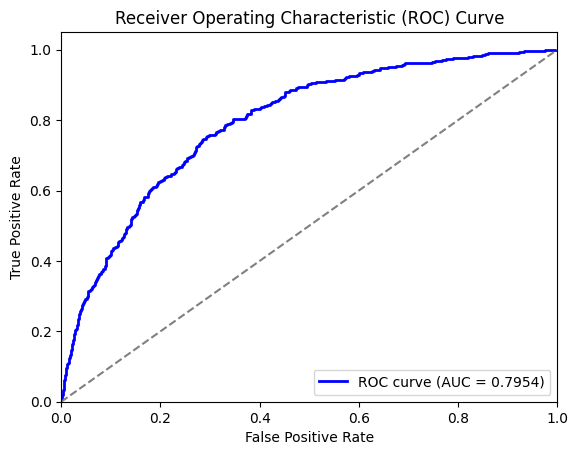

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test['target'].to_numpy(), y_pred)

# Compute AUC
auc_score = roc_auc_score(y_test['target'].to_numpy(), y_pred)
print(f"AUC Score: {auc_score:.2f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
list(zip(fpr, tpr, thresholds))

[(0.0, 0.0, 1.3164435303305249),
 (9.5047999239616e-05, 0.0, 0.3164435303305248),
 (9.5047999239616e-05, 0.0029585798816568047, 0.2920055690903219),
 (0.000380191996958464, 0.0029585798816568047, 0.2657517972074696),
 (0.000380191996958464, 0.008875739644970414, 0.2627519502149512),
 (0.0005702879954376961, 0.008875739644970414, 0.25558444203554725),
 (0.0005702879954376961, 0.011834319526627219, 0.25393594874693676),
 (0.0011405759908753922, 0.011834319526627219, 0.2450712182298546),
 (0.0011405759908753922, 0.014792899408284023, 0.2442987019351642),
 (0.002091055983271552, 0.014792899408284023, 0.23628394652405352),
 (0.002091055983271552, 0.01775147928994083, 0.23627935956098114),
 (0.0024712479802300163, 0.01775147928994083, 0.2337782600415866),
 (0.0024712479802300163, 0.026627218934911243, 0.23297294240011923),
 (0.0038969679688242564, 0.026627218934911243, 0.22748673371363728),
 (0.0038969679688242564, 0.029585798816568046, 0.22663862215720007),
 (0.003992015968063872, 0.0295857

## Prediction

In [ ]:
get_lgb_standard_loss_predictions(
    X_test.drop(columns=['WEEK_NUM']),
    folds_n=7
)

In [ ]:
get_cat_standard_loss_predictions(
    X_test.drop(columns=['WEEK_NUM']),
    folds_n=7
)

In [ ]:
get_lgb_standard_loss_predictions(
    X_test.drop(columns=['WEEK_NUM']),
    folds_n=7
)

In [ ]:
y_pred = get_predictions(
    X_test.drop(columns=['WEEK_NUM']),
    folds_n=7
)
y_pred

In [ ]:
t = (-1/7) * test_date_df['min_refreshdate_3813885D'].to_numpy()

In [ ]:
np.random.seed(42)
y_post = np.zeros(len(y_pred))
for i in range(len(y_post)):
    delta = np.random.normal(0.0, 0.05 * (145-t[i])/(145-90)) if 90<=t[i]<=145 else 0.0
    y_post[i] = y_pred[i] + delta
y_post

## Submission

In [ ]:
df_subm = pd.read_csv(ROOT / 'sample_submission.csv').set_index('case_id')
assert (df_subm.index == X_test.index).all()
df_subm['score'] = y_post
df_subm.to_csv('submission.csv')